# 📊 Clustering Authors' Samples (Train & Validation Sets)
This notebook helps analyze how samples written by each author in the dataset cluster semantically. You can use this to determine the optimal number of few-shot examples per author based on actual diversity.

# Dependencies

In [ ]:
!pip install -q sentence-transformers
!pip install kneed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.7 MB/s eta 0:00:00


In [ ]:
!pip install openpyxl python-dotenv

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Replace 'path/to/your/dataset.csv' with the actual path to your dataset file in Google Drive
train_dataset_path = '/content/drive/My Drive/AraGenEval2025/data/AuthorshipStyleTransferTrain.xlsx'
val_dataset_path =   '/content/drive/My Drive/AraGenEval2025/data/AuthorshipStyleTransferVal.xlsx'


In [ ]:
# Navigate to project folder
%cd /content/drive/MyDrive/AraGenEval2025
!ls

/content/drive/MyDrive/AraGenEval2025
analysis    fine_tuned_model_eval_pipeline.ipynb  requirements
config.py   __init__.py				  run_baseline_pipeline.py
data	    models				  run_script
EDA	    prompts				  submission
evaluation  __pycache__				  utils


In [ ]:
import sys
import os

project_root = os.getcwd()  # Should be /content/drive/MyDrive/AraGenEval2025
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root added to sys.path: {project_root}")

Project root added to sys.path: /content/drive/MyDrive/AraGenEval2025


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import gc

def load_and_sample_dataset(
    file_path,
    sample_mode="all",    # Options: "all", "random", "stratified"
    sample_size=None,     # For "random"/"stratified": float (proportion) or int (absolute count)
    random_state=42
):
    """
    Load dataset from Excel and apply sampling.

    Args:
        file_path (str): Path to dataset file.
        sample_mode (str): "all", "random", or "stratified".
        sample_size (float|int): Proportion (0-1) or count for sampling.
        random_state (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: Sampled dataset.
    """
    print(f"📂 Loading dataset from: {file_path}")
    df = pd.read_excel(file_path, engine='openpyxl')

    if sample_mode == "all":
        sampled_df = df.copy()
        print(f"✅ Loaded full dataset with {len(sampled_df)} samples.")

    elif sample_mode == "random":
        if sample_size is None:
            raise ValueError("For 'random' mode, SAMPLE_SIZE must be set.")
        sampled_df = df.sample(
            n=sample_size if isinstance(sample_size, int) else int(len(df) * sample_size),
            random_state=random_state
        )
        print(f"✅ Randomly sampled {len(sampled_df)} samples.")

    elif sample_mode == "stratified":
        if sample_size is None or not (0 < sample_size < 1):
            raise ValueError("For 'stratified' mode, SAMPLE_SIZE must be a proportion between 0 and 1.")
        sampled_df, _ = train_test_split(
            df,
            train_size=sample_size,
            stratify=df['author'],
            random_state=random_state
        )
        print(f"✅ Stratified sampled {len(sampled_df)} samples (author distribution preserved).")

    else:
        raise ValueError(f"Invalid sample_mode: {sample_mode}")

    del df
    gc.collect()

    return sampled_df


In [ ]:
from config import Config

# === CONFIG ===
SAMPLE_MODE = "stratified"  # "all", "random", "stratified"
SAMPLE_SIZE = 0.1           # 10% for stratified or random. Set to None for full dataset.

# === LOAD AND SAMPLE ===
train_df = load_and_sample_dataset(
    Config.TRAIN_FILE,
    # sample_mode=SAMPLE_MODE,
    # sample_size=SAMPLE_SIZE
)

# === LOAD AND SAMPLE ===
val_df = load_and_sample_dataset(
    Config.VAL_FILE,
    # sample_mode=SAMPLE_MODE,
    # sample_size=SAMPLE_SIZE
)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Authors in Train:", train_df['author'].nunique())
print("Authors in Val:", val_df['author'].nunique())

# train_df.head()


📂 Loading dataset from: data/AuthorshipStyleTransferTrain.xlsx
✅ Loaded full dataset with 35122 samples.
📂 Loading dataset from: data/AuthorshipStyleTransferVal.xlsx
✅ Loaded full dataset with 4157 samples.
Train shape: (35122, 4)
Validation shape: (4157, 4)
Authors in Train: 21
Authors in Val: 21


# Style Analysis

In [ ]:
from sentence_transformers import SentenceTransformer

# model = SentenceTransformer("all-MiniLM-L6-v2")

# Recommended for Arabic + paragraph-level data
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

def embed_texts(texts):
    return model.encode(texts, show_progress_bar=True)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from kneed import KneeLocator
import pickle
import hashlib


def safe_filename(name):
    hash_val = hashlib.md5(name.encode()).hexdigest()
    return f"author_{hash_val}.pkl"


def compute_k_metrics(embeddings, max_k=10):
    inertias = []
    silhouettes = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(embeddings, kmeans.labels_))
    return inertias, silhouettes


def plot_elbow(inertias, author, dataset="Train"):
    plt.figure(figsize=(6, 4))
    plt.plot(range(2, len(inertias) + 2), inertias, marker='o')
    plt.title(f"Elbow Method for {author} ({dataset})")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()


def visualize_author_clusters(df, author, dataset="Train", max_k=10, force_recompute=False, save_dir="analysis/kmeans_cache"):
    os.makedirs(save_dir, exist_ok=True)
    fname = os.path.join(save_dir, safe_filename(f"{author}_{dataset}"))

    if os.path.exists(fname) and not force_recompute:
        print(f"✅ Loading cached clustering for {author} ({dataset})...")
        with open(fname, 'rb') as f:
            result = pickle.load(f)
        embeddings = result['embeddings']
        inertias = result['inertias']
        silhouettes = result['silhouettes']
        labels = result['labels']
        best_k = result['best_k']
        best_k_knee = result['best_k_knee']
        avg_intra_dist = result['avg_intra_dist']
        mean_inter_dist = result['mean_inter_dist']
    else:
        print(f"🔄 Computing clustering for {author} ({dataset})...")
        subset = df[df['author'] == author]
        texts = subset['text_in_msa'].tolist()
        embeddings = embed_texts(texts)

        inertias, silhouettes = compute_k_metrics(embeddings, max_k=max_k)
        k_range = list(range(2, max_k + 1))
        knee = KneeLocator(k_range, inertias, curve="convex", direction="decreasing")

        best_k_knee = knee.elbow
        best_k_silhouette = k_range[np.argmax(silhouettes)]
        best_k = best_k_knee if best_k_knee else best_k_silhouette

        kmeans = KMeans(n_clusters=best_k, random_state=42).fit(embeddings)
        labels = kmeans.labels_

        intra_distances = []
        for cluster_id in range(best_k):
            cluster_points = embeddings[labels == cluster_id]
            if len(cluster_points) > 1:
                dists = pairwise_distances(cluster_points)
                mean_dist = np.mean(dists[np.triu_indices_from(dists, k=1)])
                intra_distances.append(mean_dist)
        avg_intra_dist = np.mean(intra_distances)

        centroids = kmeans.cluster_centers_
        if best_k > 1:
            inter_dists = pairwise_distances(centroids)
            mean_inter_dist = np.mean(inter_dists[np.triu_indices_from(inter_dists, k=1)])
        else:
            mean_inter_dist = np.nan

        with open(fname, 'wb') as f:
            pickle.dump({
                'embeddings': embeddings,
                'inertias': inertias,
                'silhouettes': silhouettes,
                'labels': labels,
                'best_k': best_k,
                'best_k_knee': best_k_knee if best_k_knee else 0,
                'avg_intra_dist': avg_intra_dist,
                'mean_inter_dist': mean_inter_dist
            }, f)

    print(f"📌 Suggested Best K for {author} = {best_k}")
    print(f"📏 Avg Intra-Cluster Distance: {avg_intra_dist:.4f}")
    print(f"📏 Mean Inter-Cluster Distance: {mean_inter_dist:.4f}")

    plot_elbow(inertias, author, dataset)

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette='Set2')
    plt.title(f"{author} Clusters (PCA, k={best_k}) - {dataset}")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

    return best_k, best_k_knee, avg_intra_dist, mean_inter_dist

In [ ]:
def run_kmeans_per_author(df, dataset_name="Train", max_k=10, visualize=True, save_csv=True, force_recompute=False):
    authors = df['author'].unique()
    author_k_table = []

    total_authors = len(authors)
    for idx, author in enumerate(authors, start=1):
        print(f"\n==============================")
        print(f"📚 ({idx}/{total_authors}) Author: {author} | Dataset: {dataset_name}")
        print(f"==============================")
        try:
            best_k, best_k_knee, intra_dist, inter_dist = visualize_author_clusters(
                df, author, dataset=dataset_name, max_k=max_k, force_recompute=force_recompute)

            author_k_table.append({
                "Author": author,
                "Best_K": best_k,
                "Best_K_Knee": best_k_knee if best_k_knee else 0,
                "Samples": len(df[df['author'] == author]),
                "Avg_Intra_Cluster_Dist": intra_dist,
                "Mean_Inter_Cluster_Dist": inter_dist
            })
        except Exception as e:
            print(f"❌ Skipping {author} due to error: {str(e)}")

    summary_df = pd.DataFrame(author_k_table).sort_values("Best_K")

    if save_csv:
        os.makedirs("analysis", exist_ok=True)
        csv_path = f"analysis/kmeans_author_summary_{dataset_name.lower()}.csv"
        summary_df.to_csv(csv_path, index=False)
        print(f"📁 Saved summary to {csv_path}")

    display(summary_df.style.set_caption(f"📊 Author Style Metrics ({dataset_name})").background_gradient(cmap="YlGnBu"))

    # Additional visualizations
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        data=summary_df,
        x="Avg_Intra_Cluster_Dist",
        y="Mean_Inter_Cluster_Dist",
        hue="Best_K",
        palette="viridis",
        s=100
    )
    plt.title(f"Author Style Compactness vs. Separation ({dataset_name})")
    plt.xlabel("Avg Intra-Cluster Distance")
    plt.ylabel("Mean Inter-Cluster Distance")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.barplot(data=summary_df, x="Author", y="Best_K", hue=(summary_df['Best_K_Knee'] == 0), dodge=False)
    plt.title(f"Best K per Author ({dataset_name})")
    plt.ylabel("Best K")
    plt.xlabel("Author")
    plt.xticks(rotation=90)
    plt.legend(title="Knee Not Found", labels=["Found", "Not Found"])
    plt.tight_layout()
    plt.show()

    corr = summary_df[["Samples", "Best_K", "Avg_Intra_Cluster_Dist", "Mean_Inter_Cluster_Dist"]].corr()
    print("\n🔎 Correlation Matrix:\n")
    print(corr)

    return summary_df



📚 (1/21) Author: يوسف إدريس | Dataset: Train
🔄 Computing clustering for يوسف إدريس (Train)...


Batches:   0%|          | 0/36 [00:00<?, ?it/s]

📌 Suggested Best K for يوسف إدريس = 2
📏 Avg Intra-Cluster Distance: 3.4727
📏 Mean Inter-Cluster Distance: 1.5956


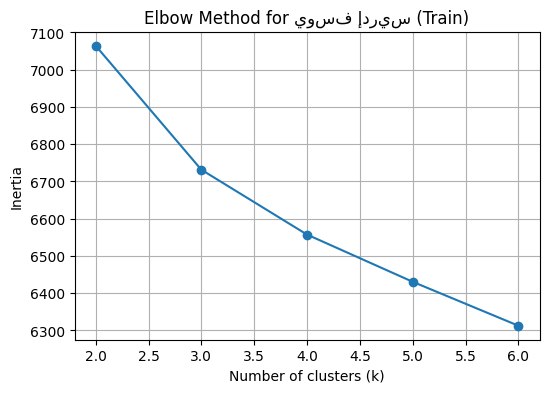

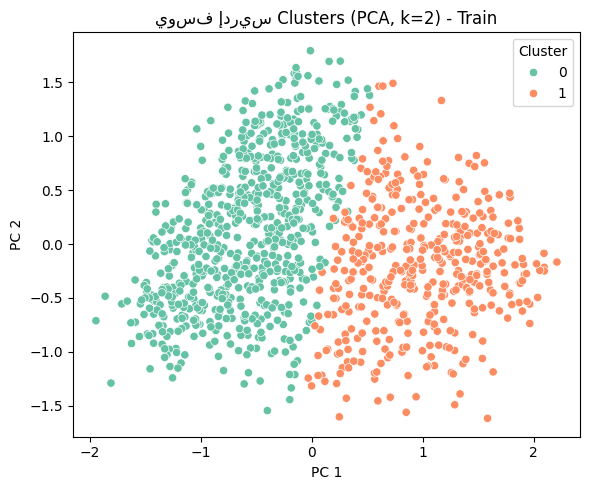


📚 (2/21) Author: فؤاد زكريا | Dataset: Train
🔄 Computing clustering for فؤاد زكريا (Train)...


Batches:   0%|          | 0/56 [00:00<?, ?it/s]

📌 Suggested Best K for فؤاد زكريا = 2
📏 Avg Intra-Cluster Distance: 3.2409
📏 Mean Inter-Cluster Distance: 1.3654


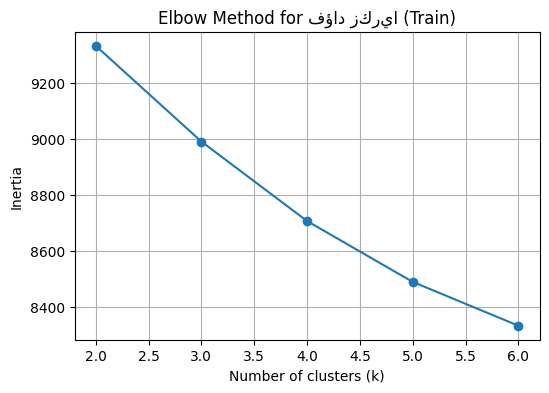

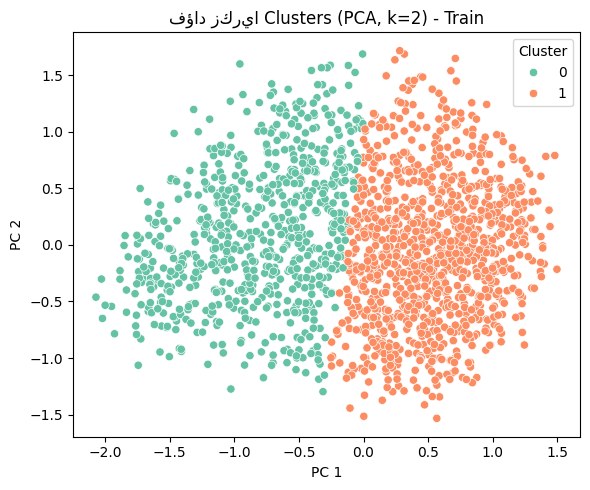


📚 (3/21) Author: حسن حنفي | Dataset: Train
🔄 Computing clustering for حسن حنفي (Train)...


Batches:   0%|          | 0/117 [00:00<?, ?it/s]

📌 Suggested Best K for حسن حنفي = 2
📏 Avg Intra-Cluster Distance: 3.1690
📏 Mean Inter-Cluster Distance: 1.6700


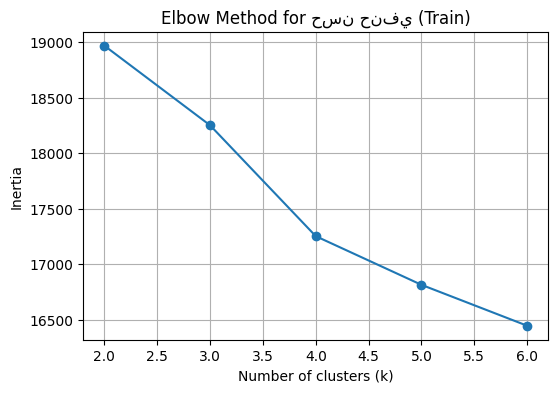

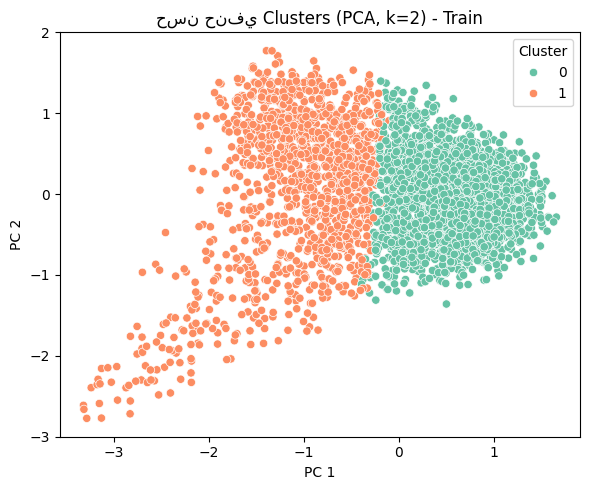


📚 (4/21) Author: عبد الغفار مكاوي | Dataset: Train
🔄 Computing clustering for عبد الغفار مكاوي (Train)...


Batches:   0%|          | 0/48 [00:00<?, ?it/s]

📌 Suggested Best K for عبد الغفار مكاوي = 2
📏 Avg Intra-Cluster Distance: 3.1708
📏 Mean Inter-Cluster Distance: 1.4421


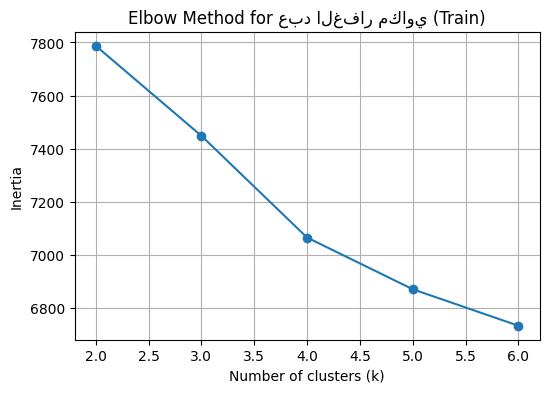

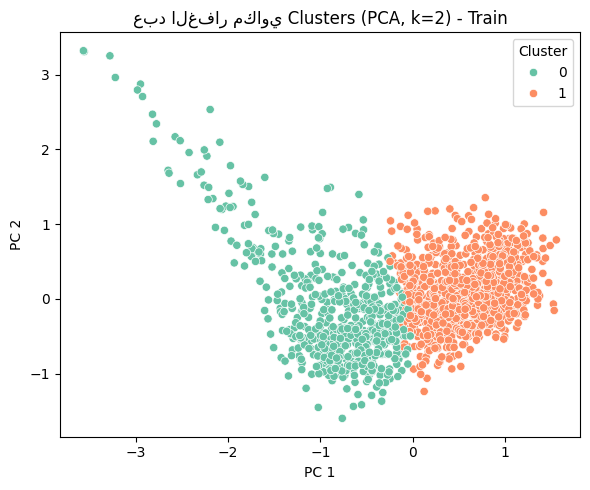


📚 (5/21) Author: كامل كيلاني | Dataset: Train
🔄 Computing clustering for كامل كيلاني (Train)...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

📌 Suggested Best K for كامل كيلاني = 2
📏 Avg Intra-Cluster Distance: 3.1206
📏 Mean Inter-Cluster Distance: 2.1325


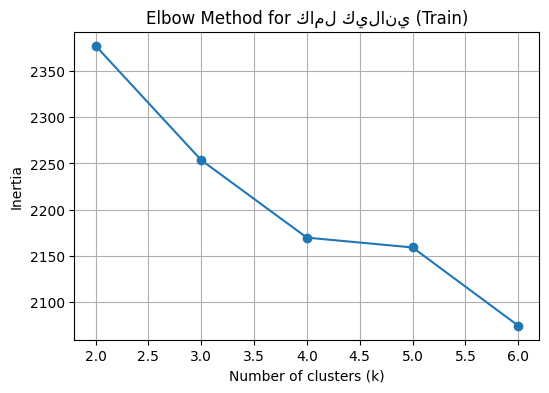

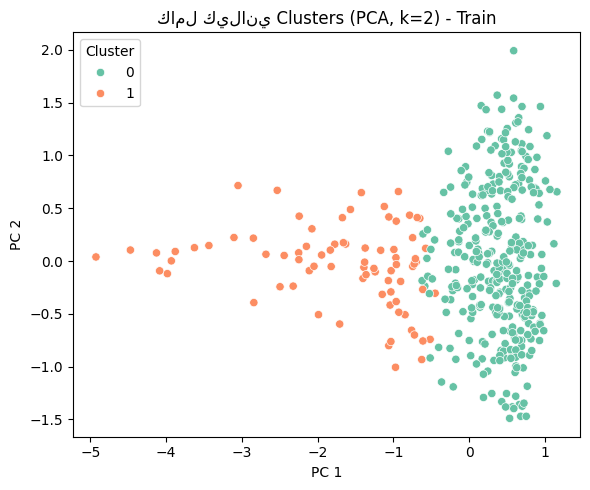


📚 (6/21) Author: نوال السعداوي | Dataset: Train
🔄 Computing clustering for نوال السعداوي (Train)...


Batches:   0%|          | 0/45 [00:00<?, ?it/s]

📌 Suggested Best K for نوال السعداوي = 2
📏 Avg Intra-Cluster Distance: 3.6089
📏 Mean Inter-Cluster Distance: 1.5753


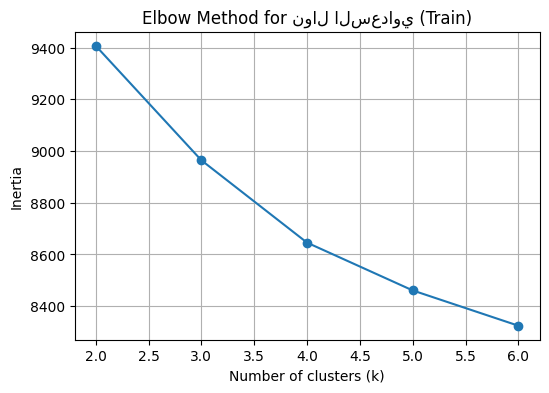

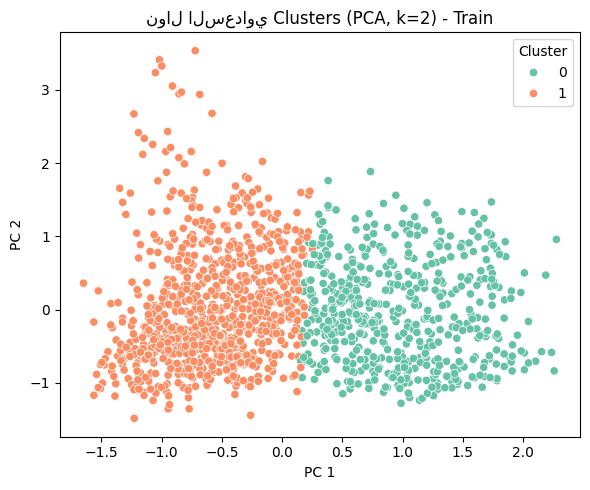


📚 (7/21) Author: أحمد شوقي | Dataset: Train
🔄 Computing clustering for أحمد شوقي (Train)...


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

📌 Suggested Best K for أحمد شوقي = 2
📏 Avg Intra-Cluster Distance: 2.4739
📏 Mean Inter-Cluster Distance: 3.3221


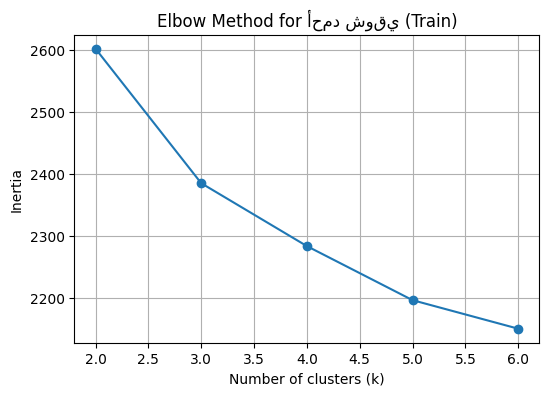

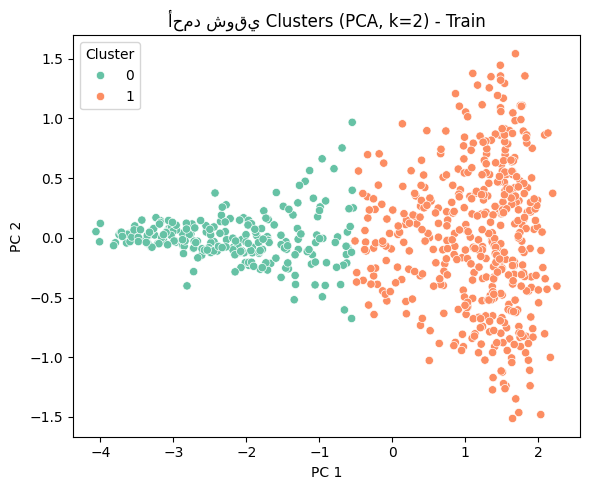


📚 (8/21) Author: أحمد تيمور باشا | Dataset: Train
🔄 Computing clustering for أحمد تيمور باشا (Train)...


Batches:   0%|          | 0/26 [00:00<?, ?it/s]

📌 Suggested Best K for أحمد تيمور باشا = 3
📏 Avg Intra-Cluster Distance: 2.4491
📏 Mean Inter-Cluster Distance: 2.3568


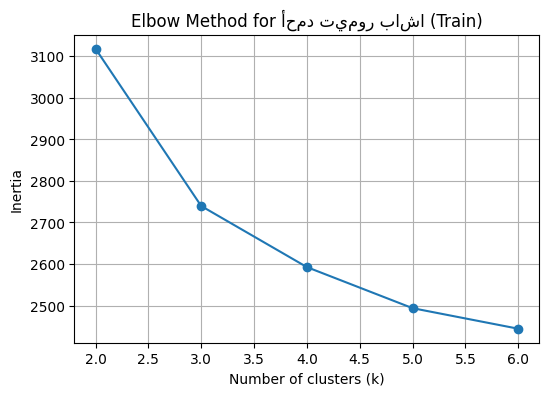

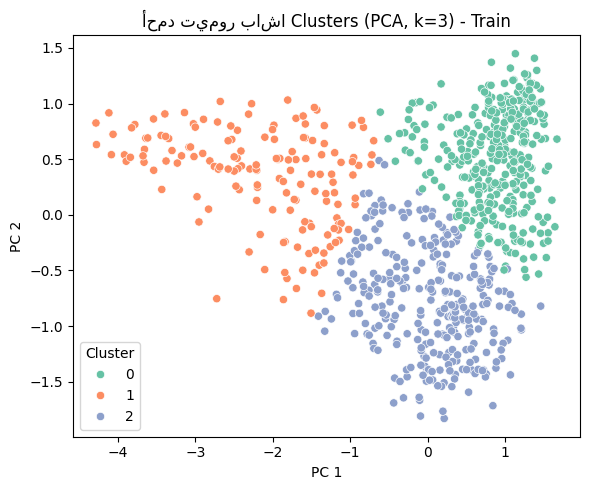


📚 (9/21) Author: ثروت أباظة | Dataset: Train
🔄 Computing clustering for ثروت أباظة (Train)...


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

📌 Suggested Best K for ثروت أباظة = 2
📏 Avg Intra-Cluster Distance: 2.9116
📏 Mean Inter-Cluster Distance: 2.6261


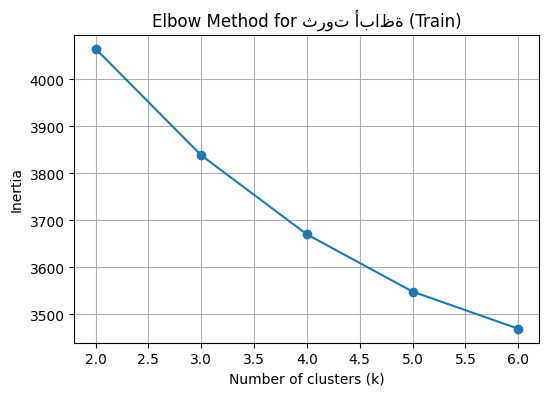

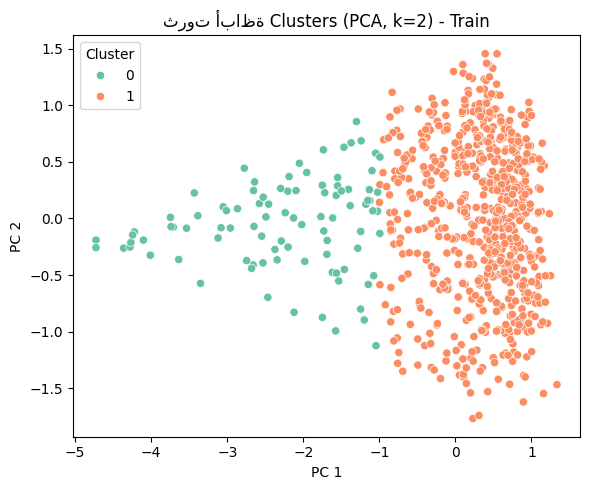


📚 (10/21) Author: سلامة موسى | Dataset: Train
🔄 Computing clustering for سلامة موسى (Train)...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

📌 Suggested Best K for سلامة موسى = 2
📏 Avg Intra-Cluster Distance: 3.5639
📏 Mean Inter-Cluster Distance: 1.3857


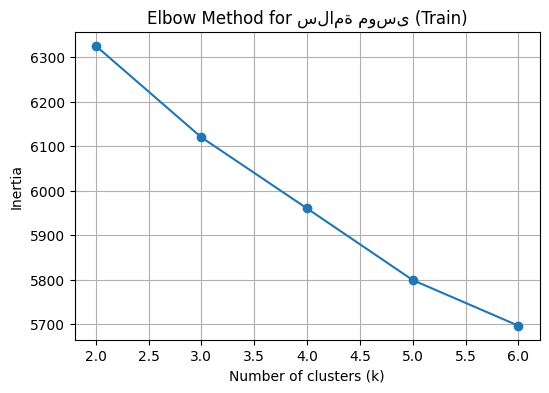

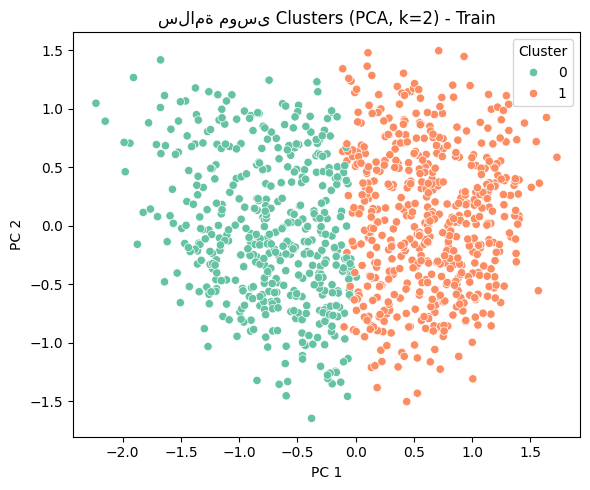


📚 (11/21) Author: جبران خليل جبران | Dataset: Train
🔄 Computing clustering for جبران خليل جبران (Train)...


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

📌 Suggested Best K for جبران خليل جبران = 2
📏 Avg Intra-Cluster Distance: 2.7092
📏 Mean Inter-Cluster Distance: 2.5089


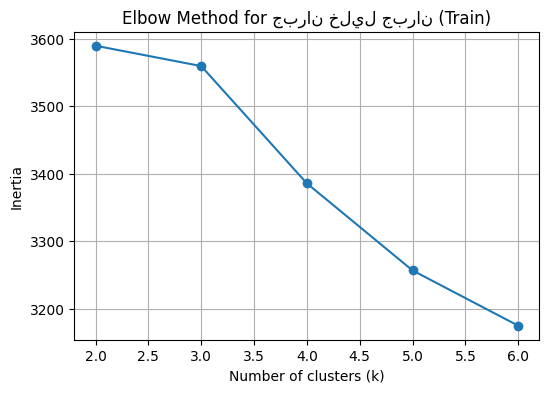

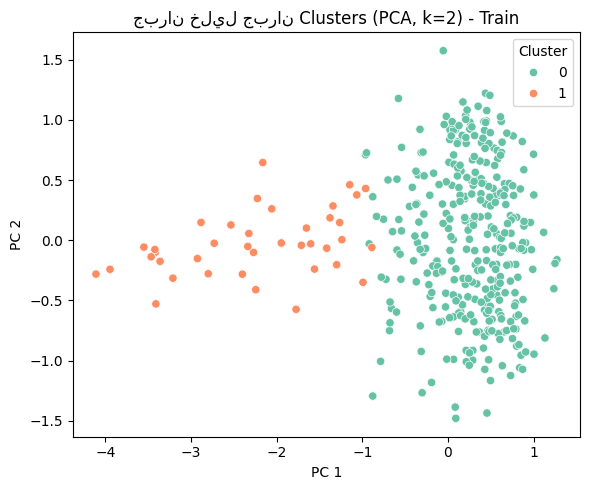


📚 (12/21) Author: روبرت بار | Dataset: Train
🔄 Computing clustering for روبرت بار (Train)...


Batches:   0%|          | 0/84 [00:00<?, ?it/s]

📌 Suggested Best K for روبرت بار = 2
📏 Avg Intra-Cluster Distance: 3.2206
📏 Mean Inter-Cluster Distance: 1.0205


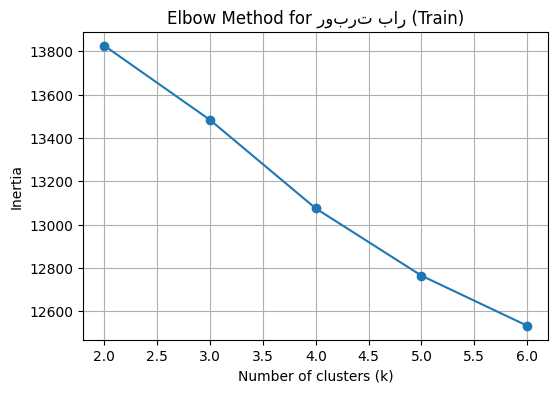

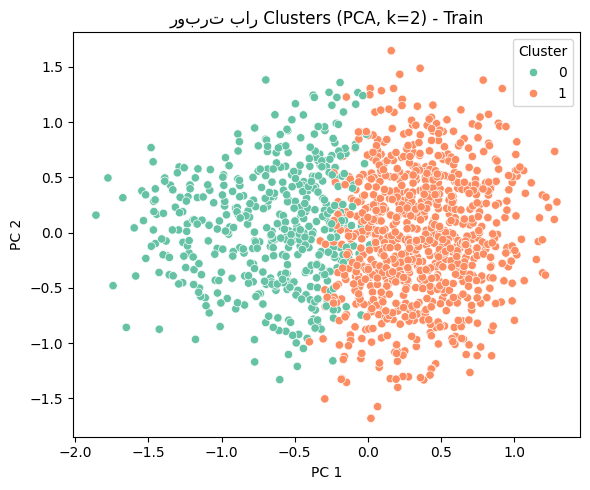


📚 (13/21) Author: ويليام شيكسبير | Dataset: Train
🔄 Computing clustering for ويليام شيكسبير (Train)...


Batches:   0%|          | 0/39 [00:00<?, ?it/s]

📌 Suggested Best K for ويليام شيكسبير = 2
📏 Avg Intra-Cluster Distance: 2.6088
📏 Mean Inter-Cluster Distance: 2.2053


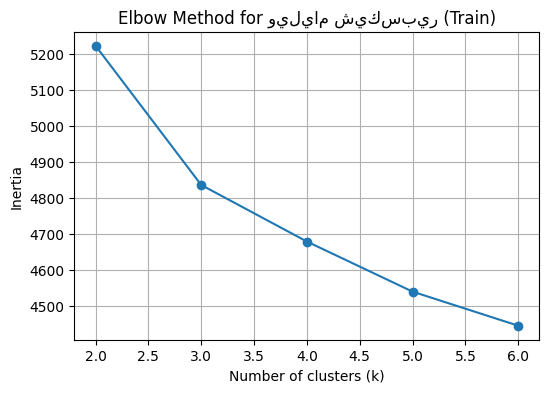

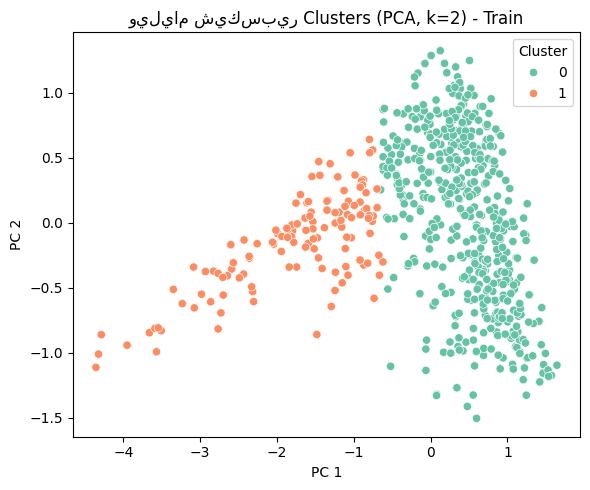


📚 (14/21) Author: طه حسين | Dataset: Train
🔄 Computing clustering for طه حسين (Train)...


Batches:   0%|          | 0/75 [00:00<?, ?it/s]

📌 Suggested Best K for طه حسين = 2
📏 Avg Intra-Cluster Distance: 2.9318
📏 Mean Inter-Cluster Distance: 2.1796


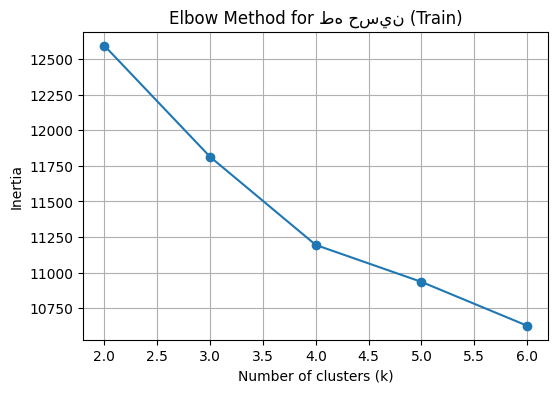

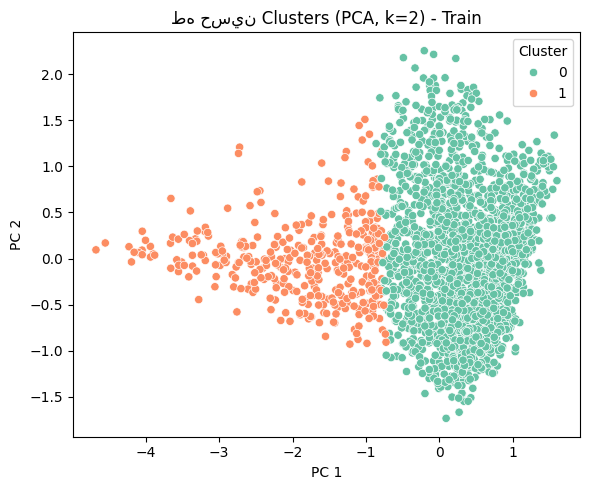


📚 (15/21) Author: أمين الريحاني | Dataset: Train
🔄 Computing clustering for أمين الريحاني (Train)...


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

📌 Suggested Best K for أمين الريحاني = 2
📏 Avg Intra-Cluster Distance: 3.0058
📏 Mean Inter-Cluster Distance: 2.2689


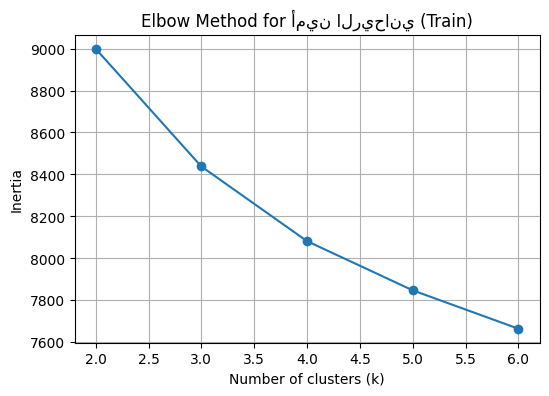

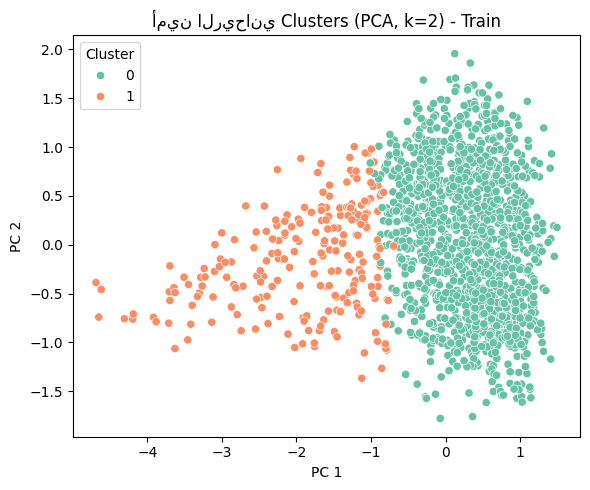


📚 (16/21) Author: غوستاف لوبون | Dataset: Train
🔄 Computing clustering for غوستاف لوبون (Train)...


Batches:   0%|          | 0/48 [00:00<?, ?it/s]

📌 Suggested Best K for غوستاف لوبون = 2
📏 Avg Intra-Cluster Distance: 3.4759
📏 Mean Inter-Cluster Distance: 1.5505


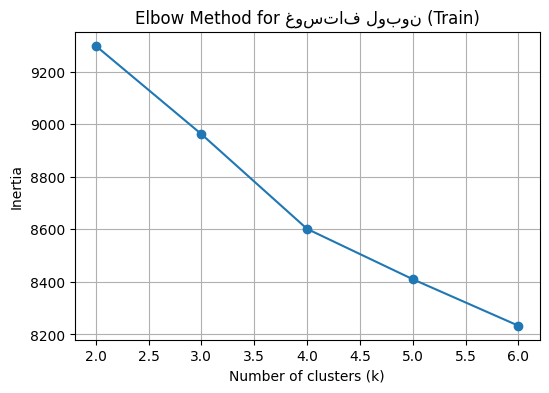

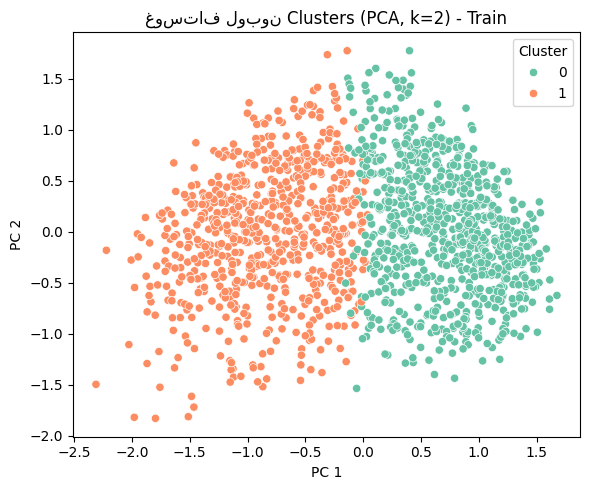


📚 (17/21) Author: نجيب محفوظ | Dataset: Train
🔄 Computing clustering for نجيب محفوظ (Train)...


Batches:   0%|          | 0/52 [00:00<?, ?it/s]

📌 Suggested Best K for نجيب محفوظ = 2
📏 Avg Intra-Cluster Distance: 2.6239
📏 Mean Inter-Cluster Distance: 2.6997


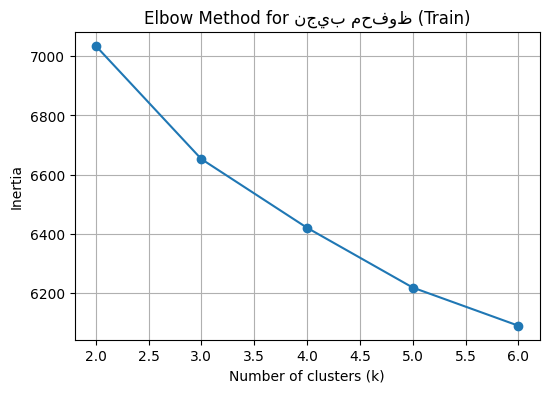

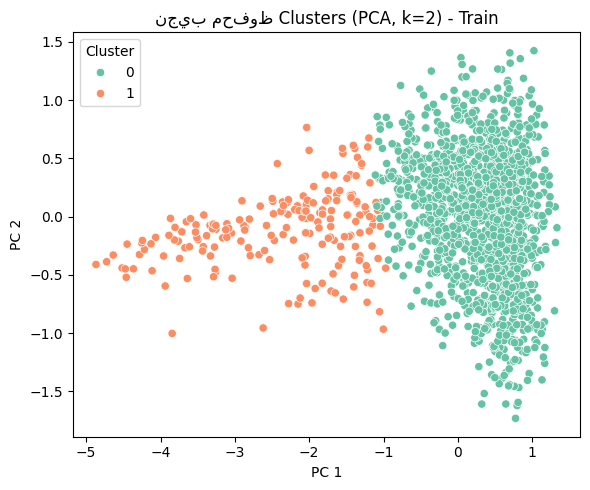


📚 (18/21) Author: أحمد أمين | Dataset: Train
🔄 Computing clustering for أحمد أمين (Train)...


Batches:   0%|          | 0/91 [00:00<?, ?it/s]

📌 Suggested Best K for أحمد أمين = 3
📏 Avg Intra-Cluster Distance: 2.8398
📏 Mean Inter-Cluster Distance: 2.2259


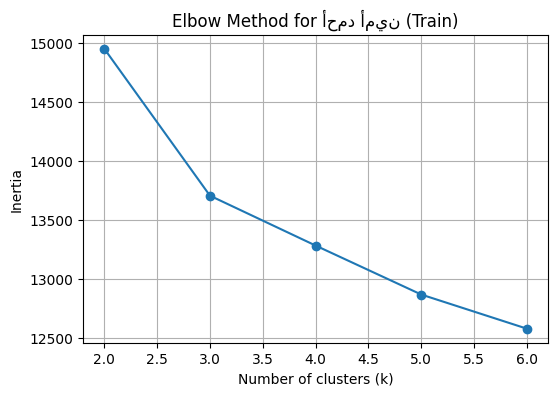

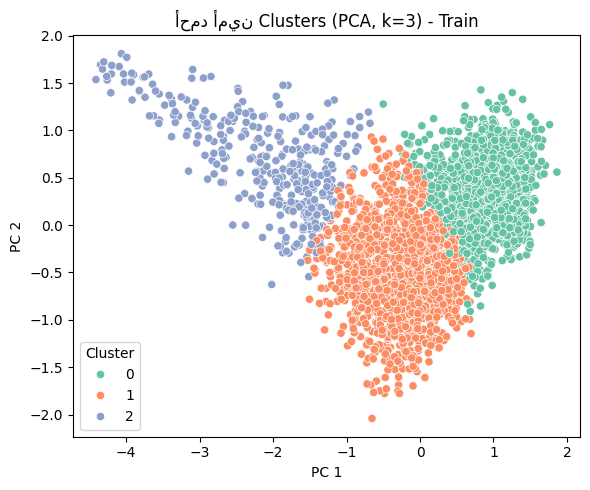


📚 (19/21) Author: محمد حسين هيكل | Dataset: Train
🔄 Computing clustering for محمد حسين هيكل (Train)...


Batches:   0%|          | 0/83 [00:00<?, ?it/s]

📌 Suggested Best K for محمد حسين هيكل = 3
📏 Avg Intra-Cluster Distance: 2.7584
📏 Mean Inter-Cluster Distance: 2.2435


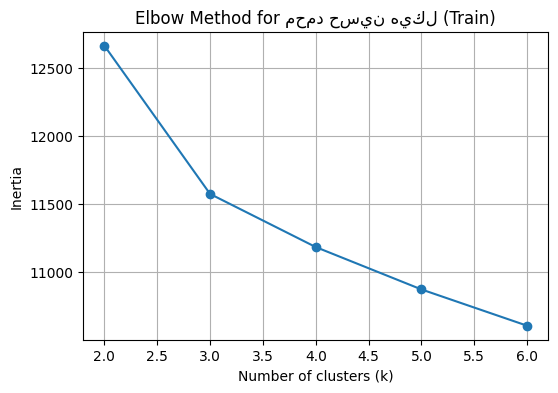

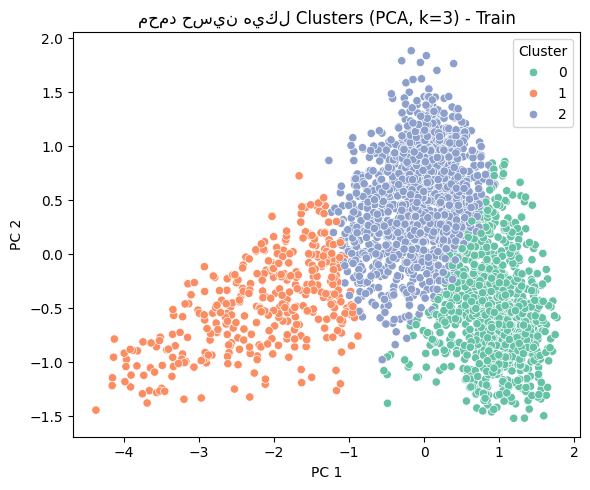


📚 (20/21) Author: جُرجي زيدان | Dataset: Train
🔄 Computing clustering for جُرجي زيدان (Train)...


Batches:   0%|          | 0/87 [00:00<?, ?it/s]

📌 Suggested Best K for جُرجي زيدان = 2
📏 Avg Intra-Cluster Distance: 2.7102
📏 Mean Inter-Cluster Distance: 2.6047


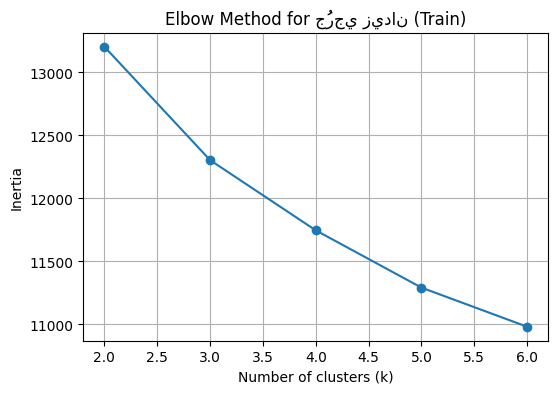

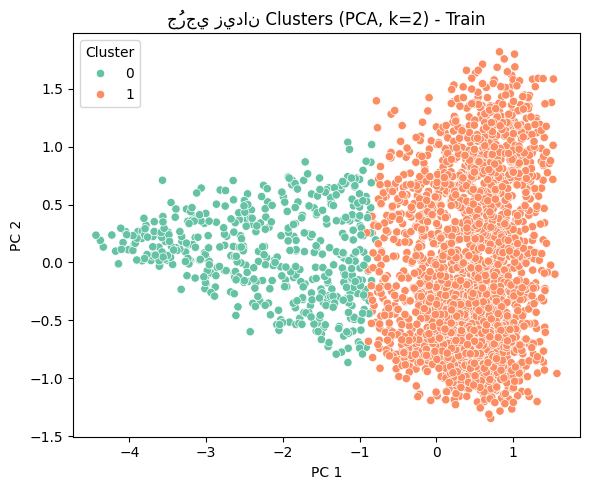


📚 (21/21) Author: عباس محمود العقاد | Dataset: Train
🔄 Computing clustering for عباس محمود العقاد (Train)...


Batches:   0%|          | 0/58 [00:00<?, ?it/s]

📌 Suggested Best K for عباس محمود العقاد = 2
📏 Avg Intra-Cluster Distance: 3.2370
📏 Mean Inter-Cluster Distance: 1.6359


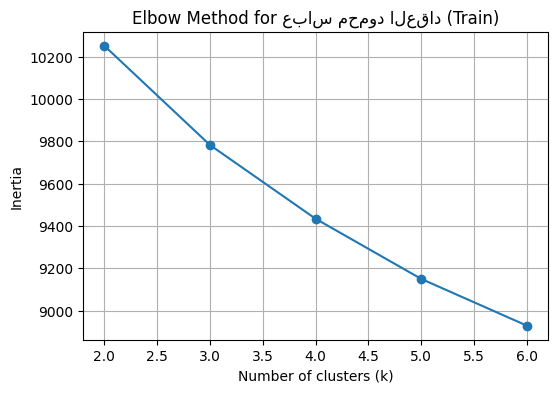

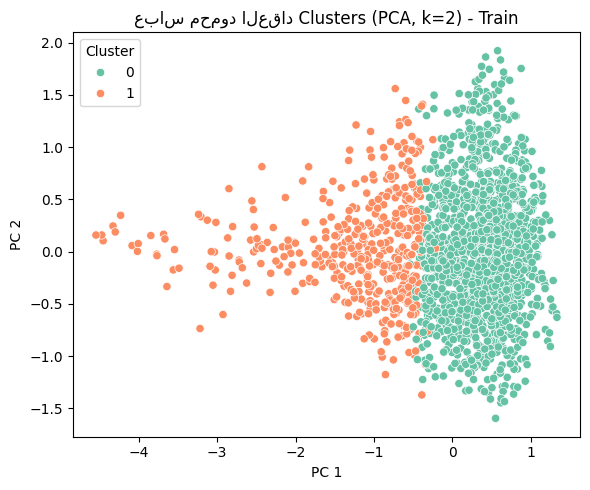

📁 Saved summary to analysis/kmeans_author_summary_train.csv


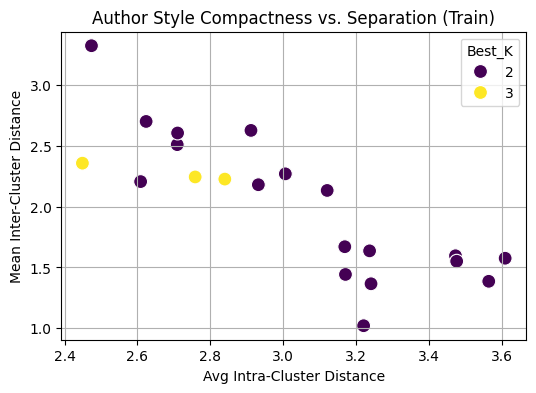

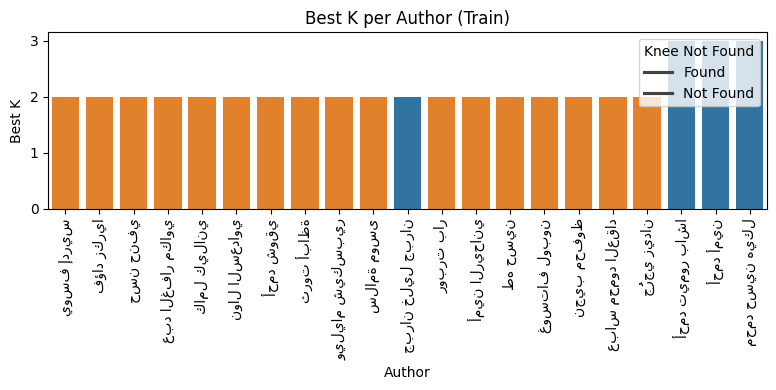


🔎 Correlation Matrix:

                          Samples    Best_K  Avg_Intra_Cluster_Dist  \
Samples                  1.000000  0.209193                0.051482   
Best_K                   0.209193  1.000000               -0.392081   
Avg_Intra_Cluster_Dist   0.051482 -0.392081                1.000000   
Mean_Inter_Cluster_Dist -0.255910  0.180913               -0.825838   

                         Mean_Inter_Cluster_Dist  
Samples                                -0.255910  
Best_K                                  0.180913  
Avg_Intra_Cluster_Dist                 -0.825838  
Mean_Inter_Cluster_Dist                 1.000000  


In [ ]:
# For training data
summary_train = run_kmeans_per_author(train_df, dataset_name="Train", max_k=6, force_recompute=True)

In [ ]:
# 📊 Style Metrics Analysis & Visualization

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_style_metrics(summary_df, dataset_name="Train"):
    """
    Visualizes style diversity and compactness metrics for a given dataset.
    Args:
        summary_df (pd.DataFrame): DataFrame containing Best_K, Intra/Inter cluster distances per author.
        dataset_name (str): Name of the dataset (for titles and clarity).
    """
    # Sort authors alphabetically for consistent plots
    summary_df = summary_df.sort_values('Author')

    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    sns.set_style("whitegrid")

    # 1. Best_K per author
    sns.barplot(data=summary_df, x='Author', y='Best_K', ax=axs[0], palette="muted")
    axs[0].set_title(f"Number of Clusters (Best_K) per Author - {dataset_name}")
    axs[0].set_ylabel("Best K (Sub-styles)")
    axs[0].tick_params(axis='x', rotation=90)

    # 2. Intra-Cluster Distance
    sns.barplot(data=summary_df, x='Author', y='Avg_Intra_Cluster_Dist', ax=axs[1], palette="muted")
    axs[1].set_title(f"Average Intra-Cluster Distance per Author - {dataset_name}")
    axs[1].set_ylabel("Mean Intra-Cluster Distance")
    axs[1].tick_params(axis='x', rotation=90)

    # 3. Inter-Cluster Distance
    sns.barplot(data=summary_df, x='Author', y='Mean_Inter_Cluster_Dist', ax=axs[2], palette="muted")
    axs[2].set_title(f"Mean Inter-Cluster Distance per Author - {dataset_name}")
    axs[2].set_ylabel("Mean Inter-Cluster Distance")
    axs[2].tick_params(axis='x', rotation=90)

    plt.suptitle(f"Author Style Diversity and Compactness - {dataset_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    # Tabular display
    styled_table = summary_df.sort_values(['Best_K', 'Avg_Intra_Cluster_Dist'], ascending=[False, False])
    display(styled_table.style.background_gradient(cmap="YlGnBu").set_caption(f"📊 Sorted Style Metrics - {dataset_name}"))

# Example usage:
# visualize_style_metrics(summary_train, dataset_name="Train")
# visualize_style_metrics(summary_val, dataset_name="Validation")


/tmp/ipython-input-13-134870906.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Author', y='Best_K', ax=axs[0], palette="muted")
/tmp/ipython-input-13-134870906.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Author', y='Avg_Intra_Cluster_Dist', ax=axs[1], palette="muted")
/tmp/ipython-input-13-134870906.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Author', y='Mean_Inter_Cluster_Dist', ax=axs[2], palette="muted")


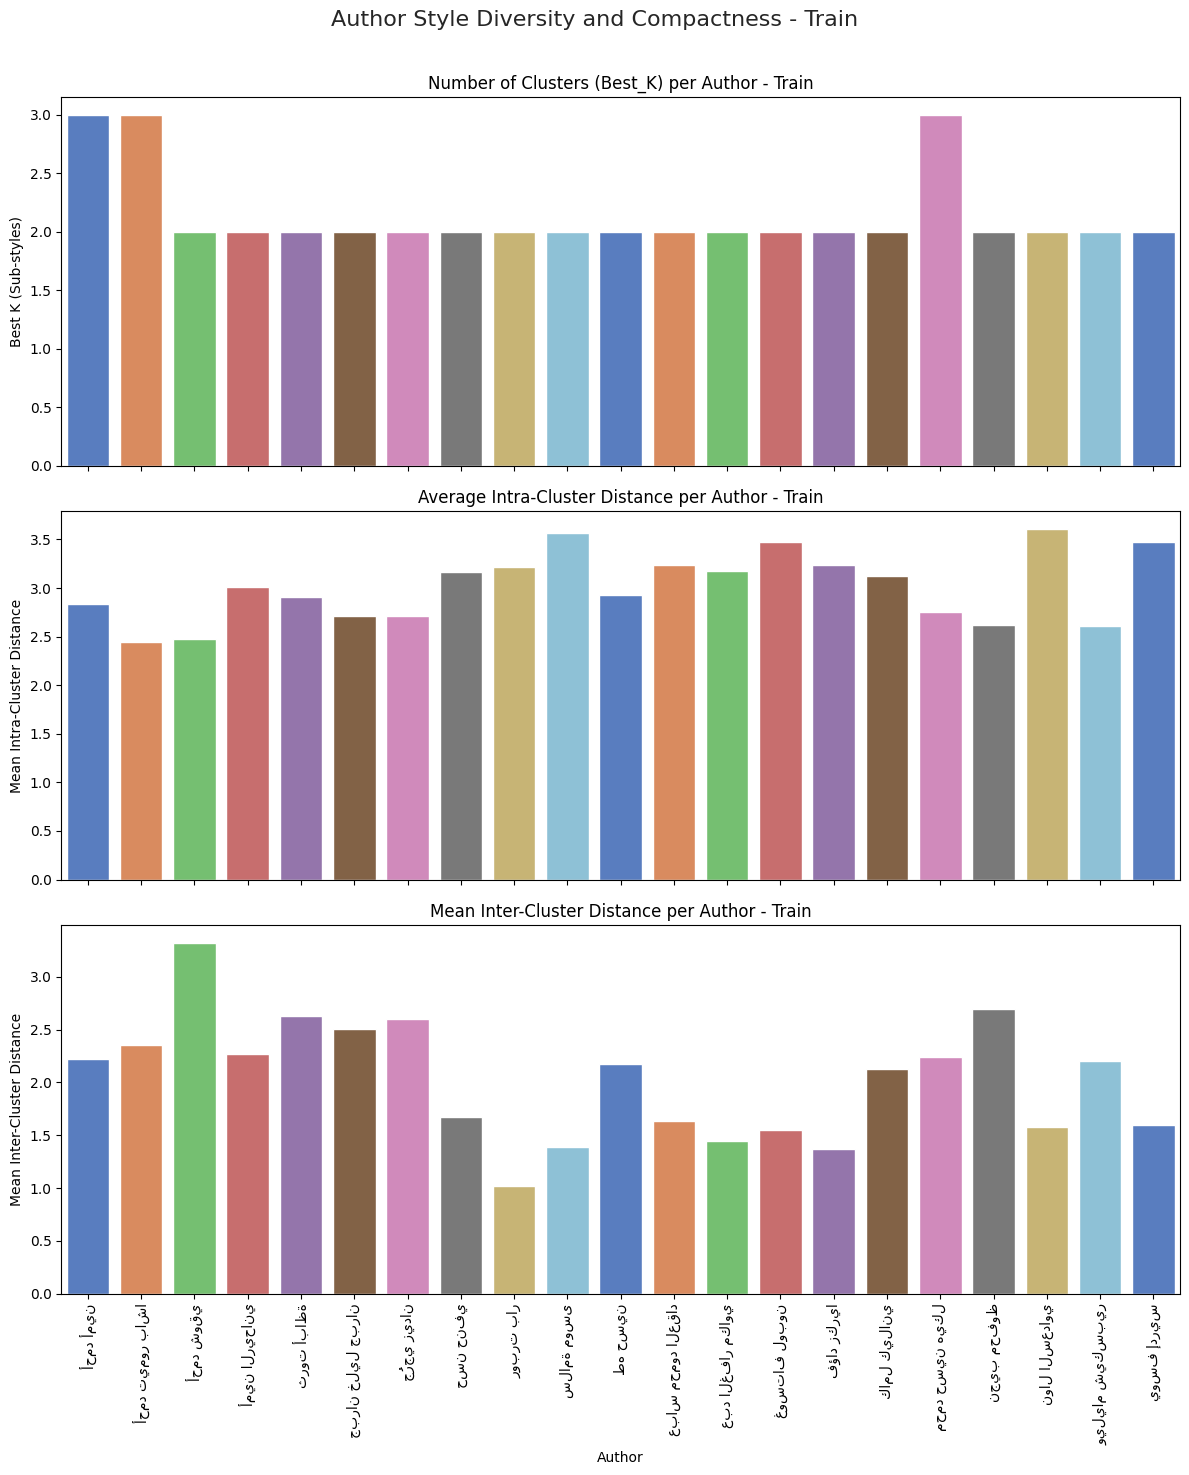

In [ ]:
visualize_style_metrics(summary_train, dataset_name="Train")

In [ ]:
import os
print(os.getcwd())


/content/drive/MyDrive/AraGenEval2025


In [ ]:
!ls analysis/kmeans_cache
!ls analysis


author_00b6eaad93d075b6ff323e8fd29bca03.pkl
author_06448696b5e733c39403ff6ea43c99c6.pkl
author_0a6df651332613c29359c0124a167c9d.pkl
author_1039ae3e85902cf24e23af150840c497.pkl
author_2f0eaec6688d355bab45989568f9b2e2.pkl
author_3156b3615d59a0821104782dd5ee0438.pkl
author_3533dade57cebc1515b651ffbc9af7cb.pkl
author_4771f763a4210ce79ed7e8e8205da25f.pkl
author_6339a4375ceef7a88540c63e3b135cdf.pkl
author_639700214f37f5ec445d5cd7243dfdb4.pkl
author_6bf5a8ca1916a6159d054b7b99691dad.pkl
author_8f0bc9dbbfa4bdaca3521e23f22faa75.pkl
author_9b9af365076661a5e9f087acee74bc62.pkl
author_c15cf7cb064c5ac39bb97e59ab06fb27.pkl
author_c47c65521d18617a712477a3855bbe9f.pkl
author_ceda77454e69450a09cc9916727232fc.pkl
author_d7fd9de0d63974aea44a1ed8d18f0ba8.pkl
author_db465eedf45a4eeb54e3bc766c9e80de.pkl
author_ee07fa422a3b85a6d9429a9b2955cbf6.pkl
author_f6ab88d25cac43325fa0e287a720fc4a.pkl
author_fb01b9d880bea8dad21c0969fe88b7b8.pkl
fewshot_model  fine_tuned_model  kmeans_author_summary_train.csv  kmeans_cac

In [ ]:
# For validation data
# summary_val = run_kmeans_per_author(val_df, dataset_name="Validation", max_k=8)

In [ ]:
# visualize_style_metrics(summary_val, dataset_name="Validation")

In [ ]:

# author_name = "يوسف إدريس"  # Change this to try different authors
# # Example:
# best_k, metrics = visualize_author_clusters(train_df, author_name, dataset="Train", max_k=8)
